# FarmVibes.AI Micro Climate Prediction

This notebook demonstrates how to train a model to forecast weather. It provides configuration to train a model and perform inference for Temperature and WindSpeed.


### Conda environment setup
Before running this notebook, let's build a conda environment. If you do not have conda installed, please follow the instructions from [Conda User Guide](https://docs.conda.io/projects/conda/en/latest/user-guide/index.html). 

```
$ conda env create -f ./deepmc_env.yaml
$ conda activate deepmc
```

### Notebook outline
The notebook is configured to train a model to infer weather parameters such as Temperature and WindSpeed. To execute the notebook, users must provide input data downloaded from a weather station. 

The **required weather features** to execute the notebook are datetime, humidity, windspeed and temperature. 
For **model training**, a minimum of 2 years of input historical data is required. Whereas, for **inference**, 552 data points of historical data are required. 

Below are the main libraries used for this example and other useful links:
- [Tensorflow](https://github.com/tensorflow/tensorflow) is used as our deep learning framework.
- [Scikit-Learn](https://github.com/scikit-learn/scikit-learn) is a Python package for machine learning built on top of SciPy. It consists of simple and efficient tools for predictive data analysis.
- [pandas](https://github.com/scikit-learn/scikit-learn) is a Python package that provides fast, flexible, and expressive data structures designed to make working with "relational" or "labeled" data both easy and intuitive.
- [NumPy](https://github.com/numpy/numpy) is a python package that provides powerful N-dimensional array object, broadcasting functions and useful linear algebra, Fourier transform, and random number capabilities.
- [pywt](https://github.com/PyWavelets/pywt) is a python package that provides mathematical basis functions that are localized in both time and frequency.


### Code organization
The training script relies on packages in `./notebook_lib` directory:

- The preprocess module (`notebook_lib/preprocess.py`) is used to preprocess, transform the input data and bundle the input data into chunks that are used for training the Micro Climate Prediction model. For more information on wavelets (check [pywavelets documentation](https://pywavelets.readthedocs.io/en/latest/)).
- The model module (`notebook_lib/models.py`, `notebook_lib/transformer_models_ts.py`, `notebook_lib/post_models.py`) contains the code for designing the model with a set of sequential tensorflow layers. If you want to change the design of the model, understand the tensorflow layers, this is probably where you should go to. Also check [tensorflow documentation](https://www.tensorflow.org/learn).
- The train/inference modules (`notebook_lib/train.py` and `notebook_lib/predict.py`) contains the code for running/training/evaluating the neural network: instantiating the neural network, training steps, computing metrics, and others. If you want to understand the mode performance, the loss, and generally how the model is trained, this is probably where you should go to. Also check [tensorflow documentation](https://www.tensorflow.org/learn).
- The module `notebook_lib/utils.py` contains commonly used functions to read csv files, scale and split data, etc.

### Imports & Constants

In [1]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
from datetime import timedelta

from notebook_lib import utils
from notebook_lib import prediction
from notebook_lib import preprocess
from notebook_lib import train

from enum import Enum

import warnings
warnings.filterwarnings("ignore")

2022-10-31 20:46:34.896120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 20:46:35.232640: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-31 20:46:35.313688: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-31 20:46:35.313720: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
# weather dataset filtered and model training limited to train features.
MODEL_TRAIN_FEATURES = ['humidity', 'wind_speed', 'temperature']

# Models trained to predict out features
MODEL_OUT_FEATURES = ['wind_speed', 'temperature']

# Historical data aligned using INDEX variable
INDEX = "date"

### AGWeatherNet
In this notebook, we utilize data downloaded from AGWeatherNet for a station \"Palouse\". The data used for training range from May 2020 to June 2022. For more information check [AGWeatherNet documentation](http://weather.wsu.edu/?p=92850&desktop).

In [3]:
# AGWeatherNet station
STATION_NAME = "Palouse"

### Data
The data downloaded from AGWeatherNet has a 15-minute frequency. On the downloaded data, the following preprocessing steps are performed:

1. The index variable is converted to datetime
2. The input data is interpolated to fill the missing values using their neighbors
3. The script focuses on training the model with a 60-minute frequency, hence the data is grouped for this frequency.
4. The data is scaled using the scikit-learn StandardScalar. For more information check [scikit-learn documentaion](https://github.com/scikit-learn/scikit-learn)

In [4]:
# Get csv data for a station
file_path = f"./data/{STATION_NAME}/training.csv"
predict="%s"
root_path = f"./data/model_{predict}/"
data_export_path = root_path + f"{STATION_NAME}/train_data.pkl"

### Training

The script is configured to train the Micro Climate prediction model for 24 hours and the actual weather station data has points with a 60-minute frequency. Below inputs vary based on number of hours of prediction and frequency of weather station data points.

1. `chunk_size` - The value of the chunk size is based on the frequency of the weather station data points. For a frequency of 60 minutes, the minimum required data points are 528. If the data frequency is 15 minutes, the minimum number of data points required is 528*4 = 2112. These are the minimum number of data points need to be provided as input during the inference.
2. `ts_lookahead` - The value used during the data preprocessing. It is the value used to consider weather data points ahead for a given time period while grouping the data.
3. `ts_lookback` - The value used during the data preprocessing. It is the value used to consider weather data points back for a given time period while grouping the data.
4. `total_models` - To perform a 24-hour prediction with a weather data point having a frequency of 60 minutes, 24 models are required. One model for each 60-minute window. If the number of hours of prediction are increased, then the total number of data points are increased. 
5. `wavelet` - Wavelet object name used to perform discrete transformation of data. The current notebook is configured to use `bior3.5`. For more information check [Discrete Wavelet Transform documentation](https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html)

### Model Types
The training process creates two different types of models: 
1. `Micro climate prediction model` - Used to predict the weather forecast. 
2. `Micro climate post-prediction model`- Scale the predicted weather forecast values using the training input data and reduce the error in prediction output.

In [8]:
input_df = utils.get_csv_data(path=file_path)

train_weather = train.ModelTrainWeather(
    train_features=MODEL_TRAIN_FEATURES,
    out_features=MODEL_OUT_FEATURES,
    root_path=root_path,
    data_export_path=data_export_path,
    station_name=STATION_NAME)

train_weather.train_model(input_df)

Epoch 1/20
1857/1857 [==============================] - 180s 82ms/step - loss: 0.5057 - val_loss: 0.1527
Epoch 2/20
1857/1857 [==============================] - 184s 99ms/step - loss: 0.1751 - val_loss: 0.1309
Epoch 3/20
1857/1857 [==============================] - 164s 88ms/step - loss: 0.1213 - val_loss: 0.0723
Epoch 4/20
1857/1857 [==============================] - 174s 94ms/step - loss: 0.0888 - val_loss: 0.0616
Epoch 5/20
1857/1857 [==============================] - 175s 95ms/step - loss: 0.0825 - val_loss: 0.0610
Epoch 6/20
1857/1857 [==============================] - 161s 87ms/step - loss: 0.0715 - val_loss: 0.0537
Epoch 7/20
1857/1857 [==============================] - 164s 89ms/step - loss: 0.0666 - val_loss: 0.0507
Epoch 8/20
1857/1857 [==============================] - 166s 89ms/step - loss: 0.0614 - val_loss: 0.0458
Epoch 9/20
1857/1857 [==============================] - 175s 95ms/step - loss: 0.0566 - val_loss: 0.0535
Epoch 10/20
1857/1857 [==============================] 

465/465 [==============================] - 10s 21ms/step
Epoch 1/20
1854/1854 [==============================] - 7s 3ms/step - loss: 0.3731 - val_loss: 0.1289
Epoch 2/20
1854/1854 [==============================] - 7s 4ms/step - loss: 0.3360 - val_loss: 0.1522
Epoch 3/20
1854/1854 [==============================] - 8s 4ms/step - loss: 0.3298 - val_loss: 0.1063
Epoch 4/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3209 - val_loss: 0.1455
Epoch 5/20
1854/1854 [==============================] - 7s 4ms/step - loss: 0.3181 - val_loss: 0.1024
Epoch 6/20
1854/1854 [==============================] - 7s 4ms/step - loss: 0.3126 - val_loss: 0.1704
Epoch 7/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3091 - val_loss: 0.0988
Epoch 8/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3122 - val_loss: 0.0901
Epoch 9/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3125 - val_loss: 0.0974
Epoch 10/20
1854/1854 [==

465/465 [==============================] - 9s 19ms/step
Epoch 1/20
1854/1854 [==============================] - 8s 4ms/step - loss: 0.3788 - val_loss: 0.1435
Epoch 2/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3387 - val_loss: 0.1442
Epoch 3/20
1854/1854 [==============================] - 8s 5ms/step - loss: 0.3355 - val_loss: 0.1441
Epoch 4/20
1854/1854 [==============================] - 7s 4ms/step - loss: 0.3309 - val_loss: 0.1411
Epoch 5/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3263 - val_loss: 0.1268
Epoch 6/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3136 - val_loss: 0.1218
Epoch 7/20
1854/1854 [==============================] - 7s 4ms/step - loss: 0.3189 - val_loss: 0.1313
Epoch 8/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3148 - val_loss: 0.1836
Epoch 9/20
1854/1854 [==============================] - 8s 4ms/step - loss: 0.3131 - val_loss: 0.1208
Epoch 10/20
1854/1854 [===

465/465 [==============================] - 8s 18ms/step
Epoch 1/20
1854/1854 [==============================] - 8s 4ms/step - loss: 0.3812 - val_loss: 0.1580
Epoch 2/20
1854/1854 [==============================] - 9s 5ms/step - loss: 0.3508 - val_loss: 0.1301
Epoch 3/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3459 - val_loss: 0.1247
Epoch 4/20
1854/1854 [==============================] - 8s 4ms/step - loss: 0.3270 - val_loss: 0.1886
Epoch 5/20
1854/1854 [==============================] - 8s 4ms/step - loss: 0.3293 - val_loss: 0.1433
Epoch 6/20
1854/1854 [==============================] - 7s 4ms/step - loss: 0.3214 - val_loss: 0.1207
Epoch 7/20
1854/1854 [==============================] - 8s 4ms/step - loss: 0.3162 - val_loss: 0.1253
Epoch 8/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3221 - val_loss: 0.1689
Epoch 9/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3163 - val_loss: 0.1167
Epoch 10/20
1854/1854 [===

465/465 [==============================] - 10s 22ms/step
Epoch 1/20
1854/1854 [==============================] - 9s 4ms/step - loss: 0.3915 - val_loss: 0.1950
Epoch 2/20
1854/1854 [==============================] - 8s 4ms/step - loss: 0.3558 - val_loss: 0.1901
Epoch 3/20
1854/1854 [==============================] - 9s 5ms/step - loss: 0.3498 - val_loss: 0.2105
Epoch 4/20
1854/1854 [==============================] - 7s 4ms/step - loss: 0.3406 - val_loss: 0.1634
Epoch 5/20
1854/1854 [==============================] - 8s 4ms/step - loss: 0.3352 - val_loss: 0.1699
Epoch 6/20
1854/1854 [==============================] - 8s 4ms/step - loss: 0.3382 - val_loss: 0.1581
Epoch 7/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3342 - val_loss: 0.1825
Epoch 8/20
1854/1854 [==============================] - 10s 5ms/step - loss: 0.3355 - val_loss: 0.1544
Epoch 9/20
1854/1854 [==============================] - 7s 4ms/step - loss: 0.3320 - val_loss: 0.1706
Epoch 10/20
1854/1854 [=

465/465 [==============================] - 5s 11ms/step
Epoch 1/20
1854/1854 [==============================] - 7s 3ms/step - loss: 0.3932 - val_loss: 0.1882
Epoch 2/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3625 - val_loss: 0.1751
Epoch 3/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3468 - val_loss: 0.1808
Epoch 4/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3415 - val_loss: 0.1659
Epoch 5/20
1854/1854 [==============================] - 8s 4ms/step - loss: 0.3425 - val_loss: 0.1805
Epoch 6/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3341 - val_loss: 0.2075
Epoch 7/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3371 - val_loss: 0.1919
Epoch 8/20
1854/1854 [==============================] - 8s 5ms/step - loss: 0.3360 - val_loss: 0.1674
Epoch 9/20
1854/1854 [==============================] - 7s 4ms/step - loss: 0.3374 - val_loss: 0.1671
Epoch 10/20
1854/1854 [===

465/465 [==============================] - 4s 9ms/step
Epoch 1/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.4093 - val_loss: 0.2195
Epoch 2/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3801 - val_loss: 0.2215
Epoch 3/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3649 - val_loss: 0.2068
Epoch 4/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3714 - val_loss: 0.2024
Epoch 5/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3612 - val_loss: 0.2265
Epoch 6/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3585 - val_loss: 0.2297
Epoch 7/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3512 - val_loss: 0.2644
Epoch 8/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3529 - val_loss: 0.2469
Epoch 9/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3436 - val_loss: 0.2024
Epoch 10/20
1854/1854 [====

465/465 [==============================] - 6s 12ms/step
Epoch 1/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.4062 - val_loss: 0.2270
Epoch 2/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3766 - val_loss: 0.2439
Epoch 3/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3697 - val_loss: 0.1965
Epoch 4/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3635 - val_loss: 0.2077
Epoch 5/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3595 - val_loss: 0.2073
Epoch 6/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3557 - val_loss: 0.1991
Epoch 7/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3522 - val_loss: 0.1916
Epoch 8/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3546 - val_loss: 0.1949
Epoch 9/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3510 - val_loss: 0.2012
Epoch 10/20
1854/1854 [===

465/465 [==============================] - 6s 13ms/step
Epoch 1/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.4098 - val_loss: 0.2373
Epoch 2/20
1854/1854 [==============================] - 5s 2ms/step - loss: 0.3824 - val_loss: 0.2157
Epoch 3/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3686 - val_loss: 0.2307
Epoch 4/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3657 - val_loss: 0.2189
Epoch 5/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3746 - val_loss: 0.2246
Epoch 6/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3560 - val_loss: 0.2162
Epoch 7/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3632 - val_loss: 0.2220
Epoch 8/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3560 - val_loss: 0.2138
Epoch 9/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3552 - val_loss: 0.2099
Epoch 10/20
1854/1854 [===

465/465 [==============================] - 5s 11ms/step
Epoch 1/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.4100 - val_loss: 0.2473
Epoch 2/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3790 - val_loss: 0.2809
Epoch 3/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3782 - val_loss: 0.2219
Epoch 4/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3736 - val_loss: 0.2399
Epoch 5/20
1854/1854 [==============================] - 5s 2ms/step - loss: 0.3678 - val_loss: 0.2344
Epoch 6/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3653 - val_loss: 0.2134
Epoch 7/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3614 - val_loss: 0.2107
Epoch 8/20
1854/1854 [==============================] - 5s 2ms/step - loss: 0.3673 - val_loss: 0.2189
Epoch 9/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3570 - val_loss: 0.2327
Epoch 10/20
1854/1854 [===

465/465 [==============================] - 5s 12ms/step
Epoch 1/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.4198 - val_loss: 0.2421
Epoch 2/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3909 - val_loss: 0.2377
Epoch 3/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3792 - val_loss: 0.2734
Epoch 4/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3796 - val_loss: 0.2615
Epoch 5/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3726 - val_loss: 0.2429
Epoch 6/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3714 - val_loss: 0.2254
Epoch 7/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3681 - val_loss: 0.2421
Epoch 8/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3654 - val_loss: 0.2193
Epoch 9/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3633 - val_loss: 0.2318
Epoch 10/20
1854/1854 [===

465/465 [==============================] - 4s 8ms/step
Epoch 1/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.4245 - val_loss: 0.2811
Epoch 2/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3998 - val_loss: 0.2650
Epoch 3/20
1854/1854 [==============================] - 5s 2ms/step - loss: 0.3888 - val_loss: 0.2929
Epoch 4/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3847 - val_loss: 0.2918
Epoch 5/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3798 - val_loss: 0.2703
Epoch 6/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3781 - val_loss: 0.2549
Epoch 7/20
1854/1854 [==============================] - 5s 2ms/step - loss: 0.3750 - val_loss: 0.2617
Epoch 8/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3712 - val_loss: 0.2730
Epoch 9/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3680 - val_loss: 0.2732
Epoch 10/20
1854/1854 [====

465/465 [==============================] - 4s 8ms/step
Epoch 1/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.4203 - val_loss: 0.2509
Epoch 2/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3953 - val_loss: 0.2380
Epoch 3/20
1854/1854 [==============================] - 5s 2ms/step - loss: 0.3899 - val_loss: 0.2796
Epoch 4/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3829 - val_loss: 0.2360
Epoch 5/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3799 - val_loss: 0.2455
Epoch 6/20
1854/1854 [==============================] - 5s 2ms/step - loss: 0.3812 - val_loss: 0.2342
Epoch 7/20
1854/1854 [==============================] - 5s 2ms/step - loss: 0.3690 - val_loss: 0.2575
Epoch 8/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3706 - val_loss: 0.2252
Epoch 9/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3677 - val_loss: 0.2377
Epoch 10/20
1854/1854 [====

465/465 [==============================] - 4s 9ms/step
Epoch 1/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.4243 - val_loss: 0.2873
Epoch 2/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3918 - val_loss: 0.2377
Epoch 3/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3858 - val_loss: 0.2403
Epoch 4/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3801 - val_loss: 0.2409
Epoch 5/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3745 - val_loss: 0.2343
Epoch 6/20
1854/1854 [==============================] - 5s 2ms/step - loss: 0.3786 - val_loss: 0.2659
Epoch 7/20
1854/1854 [==============================] - 5s 2ms/step - loss: 0.3748 - val_loss: 0.2492
Epoch 8/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3746 - val_loss: 0.2263
Epoch 9/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3721 - val_loss: 0.2428
Epoch 10/20
1854/1854 [====

465/465 [==============================] - 6s 13ms/step
Epoch 1/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.4198 - val_loss: 0.2740
Epoch 2/20
1854/1854 [==============================] - 5s 2ms/step - loss: 0.3923 - val_loss: 0.2460
Epoch 3/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3866 - val_loss: 0.2337
Epoch 4/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3813 - val_loss: 0.2418
Epoch 5/20
1854/1854 [==============================] - 5s 2ms/step - loss: 0.3771 - val_loss: 0.2466
Epoch 6/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3731 - val_loss: 0.2341
Epoch 7/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3692 - val_loss: 0.2569
Epoch 8/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3740 - val_loss: 0.2323
Epoch 9/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3718 - val_loss: 0.2303
Epoch 10/20
1854/1854 [===

465/465 [==============================] - 4s 8ms/step
Epoch 1/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.4249 - val_loss: 0.2896
Epoch 2/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3918 - val_loss: 0.2400
Epoch 3/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3858 - val_loss: 0.2494
Epoch 4/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3894 - val_loss: 0.2428
Epoch 5/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3806 - val_loss: 0.2468
Epoch 6/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3778 - val_loss: 0.2705
Epoch 7/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3796 - val_loss: 0.2322
Epoch 8/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3826 - val_loss: 0.2374
Epoch 9/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3745 - val_loss: 0.2468
Epoch 10/20
1854/1854 [====

465/465 [==============================] - 6s 13ms/step
Epoch 1/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.4254 - val_loss: 0.2882
Epoch 2/20
1854/1854 [==============================] - 5s 2ms/step - loss: 0.4006 - val_loss: 0.2644
Epoch 3/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3980 - val_loss: 0.2796
Epoch 4/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3920 - val_loss: 0.2657
Epoch 5/20
1854/1854 [==============================] - 5s 2ms/step - loss: 0.3907 - val_loss: 0.2986
Epoch 6/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3847 - val_loss: 0.2554
Epoch 7/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3792 - val_loss: 0.2609
Epoch 8/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3823 - val_loss: 0.2618
Epoch 9/20
1854/1854 [==============================] - 5s 2ms/step - loss: 0.3791 - val_loss: 0.2602
Epoch 10/20
1854/1854 [===

465/465 [==============================] - 4s 9ms/step
Epoch 1/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.4225 - val_loss: 0.2561
Epoch 2/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3931 - val_loss: 0.2939
Epoch 3/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3877 - val_loss: 0.2348
Epoch 4/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3863 - val_loss: 0.2732
Epoch 5/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3813 - val_loss: 0.2406
Epoch 6/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3728 - val_loss: 0.2541
Epoch 7/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3741 - val_loss: 0.2393
Epoch 8/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3691 - val_loss: 0.2334
Epoch 9/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3734 - val_loss: 0.2543
Epoch 10/20
1854/1854 [====

465/465 [==============================] - 6s 13ms/step
Epoch 1/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.4299 - val_loss: 0.2607
Epoch 2/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3971 - val_loss: 0.2943
Epoch 3/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3910 - val_loss: 0.2582
Epoch 4/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3853 - val_loss: 0.2514
Epoch 5/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3885 - val_loss: 0.2553
Epoch 6/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3793 - val_loss: 0.2566
Epoch 7/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3833 - val_loss: 0.2559
Epoch 8/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3769 - val_loss: 0.2537
Epoch 9/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3771 - val_loss: 0.2765
Epoch 10/20
1854/1854 [===

465/465 [==============================] - 5s 11ms/step
Epoch 1/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.4296 - val_loss: 0.2625
Epoch 2/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3978 - val_loss: 0.2463
Epoch 3/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3892 - val_loss: 0.2873
Epoch 4/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3884 - val_loss: 0.2478
Epoch 5/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3857 - val_loss: 0.2810
Epoch 6/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3806 - val_loss: 0.2484
Epoch 7/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3821 - val_loss: 0.2760
Epoch 8/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3780 - val_loss: 0.2408
Epoch 9/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3779 - val_loss: 0.2428
Epoch 10/20
1854/1854 [===

465/465 [==============================] - 4s 8ms/step
Epoch 1/20
1854/1854 [==============================] - 7s 3ms/step - loss: 0.4314 - val_loss: 0.2603
Epoch 2/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.4040 - val_loss: 0.2544
Epoch 3/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3885 - val_loss: 0.3116
Epoch 4/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3874 - val_loss: 0.2685
Epoch 5/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3864 - val_loss: 0.2514
Epoch 6/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3881 - val_loss: 0.2538
Epoch 7/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3814 - val_loss: 0.2485
Epoch 8/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3796 - val_loss: 0.2452
Epoch 9/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3845 - val_loss: 0.2655
Epoch 10/20
1854/1854 [====

465/465 [==============================] - 4s 9ms/step
Epoch 1/20
1854/1854 [==============================] - 7s 3ms/step - loss: 0.4281 - val_loss: 0.2726
Epoch 2/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.4008 - val_loss: 0.2812
Epoch 3/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3934 - val_loss: 0.2735
Epoch 4/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3976 - val_loss: 0.2506
Epoch 5/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3902 - val_loss: 0.2565
Epoch 6/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3886 - val_loss: 0.2625
Epoch 7/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3844 - val_loss: 0.2509
Epoch 8/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3833 - val_loss: 0.2823
Epoch 9/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3812 - val_loss: 0.2532
Epoch 10/20
1854/1854 [====

465/465 [==============================] - 4s 9ms/step
Epoch 1/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.4351 - val_loss: 0.2619
Epoch 2/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.4023 - val_loss: 0.2652
Epoch 3/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.4040 - val_loss: 0.2654
Epoch 4/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3929 - val_loss: 0.2862
Epoch 5/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3899 - val_loss: 0.2521
Epoch 6/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3883 - val_loss: 0.2729
Epoch 7/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3843 - val_loss: 0.2594
Epoch 8/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3808 - val_loss: 0.2492
Epoch 9/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3848 - val_loss: 0.2673
Epoch 10/20
1854/1854 [====

465/465 [==============================] - 6s 14ms/step
Epoch 1/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.4299 - val_loss: 0.2755
Epoch 2/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.4016 - val_loss: 0.2573
Epoch 3/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3966 - val_loss: 0.2647
Epoch 4/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3925 - val_loss: 0.2575
Epoch 5/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3911 - val_loss: 0.2503
Epoch 6/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3879 - val_loss: 0.2707
Epoch 7/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3862 - val_loss: 0.2607
Epoch 8/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3827 - val_loss: 0.2437
Epoch 9/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3751 - val_loss: 0.2553
Epoch 10/20
1854/1854 [===

465/465 [==============================] - 6s 13ms/step
Epoch 1/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.4401 - val_loss: 0.3015
Epoch 2/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.4141 - val_loss: 0.2804
Epoch 3/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.4029 - val_loss: 0.2729
Epoch 4/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.4017 - val_loss: 0.2717
Epoch 5/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.4045 - val_loss: 0.2705
Epoch 6/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3929 - val_loss: 0.2814
Epoch 7/20
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3936 - val_loss: 0.2895
Epoch 8/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3940 - val_loss: 0.2682
Epoch 9/20
1854/1854 [==============================] - 5s 3ms/step - loss: 0.3868 - val_loss: 0.2666
Epoch 10/20
1854/1854 [===

### Predicting Weather forecast
The script in the notebook is configured to infer Micro Climate prediction model for 24 hours, with actual weather station data points with a frequency of 60 minutes.

In [6]:
weather_forecast = prediction.InferenceWeather(
                        root_path=root_path,
                        data_export_path=data_export_path,
                        station_name=STATION_NAME,
                        predicts=MODEL_OUT_FEATURES)

2022-10-31 20:47:02.622016: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-31 20:47:02.622271: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-31 20:47:02.622303: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rpadilha-vm-test): /proc/driver/nvidia/version does not exist
2022-10-31 20:47:02.623074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Current
Predict weather for the next 24 hours:

In [7]:
file_path = f"./data/{STATION_NAME}/prediction.csv"
input_df = utils.get_csv_data(path=file_path)
base_data_df = input_df[MODEL_TRAIN_FEATURES]

predict_start_datetime = base_data_df.index[-1]

df_output_merge = pd.DataFrame(columns=base_data_df.columns)

df_out = weather_forecast.inference(base_data_df,
            start_datetime=predict_start_datetime
            )

2022-10-31 20:47:29.467524: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./data/model_wind_speed/Palouse/model_0/: FAILED_PRECONDITION: data/model_wind_speed/Palouse/model_0; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
2022-10-31 20:47:33.187249: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./data/model_wind_speed/Palouse/model_0/post/: FAILED_PRECONDITION: data/model_wind_speed/Palouse/model_0/post; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
2022-10-31 20:47:33.347981: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./data/model_wind_speed/Palouse/model_1/: FAILED_PRECONDITION: data/model_wind_speed/Palouse/model_1; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
2022-10-31 20:47:33.666783: W tensorflow/core/util/tensor_slice

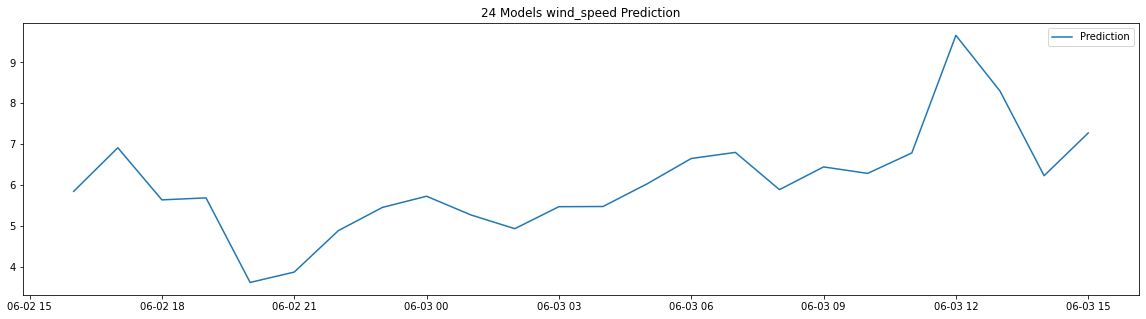

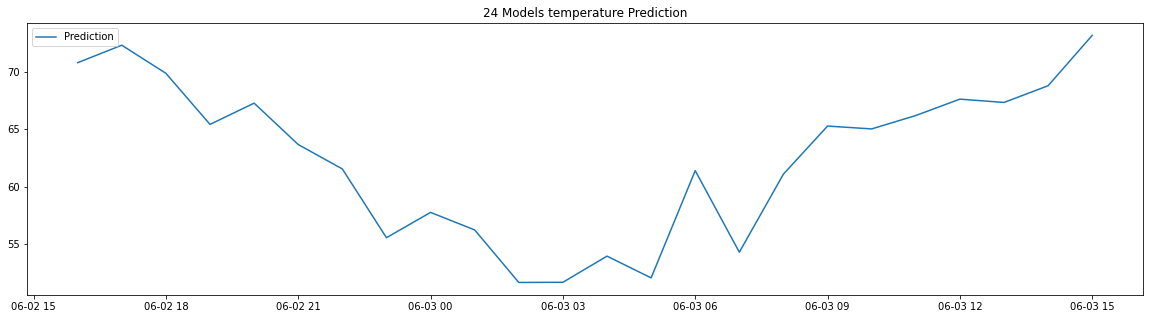

In [8]:
for predict in MODEL_OUT_FEATURES:
    plt.figure(figsize=(20, 5))
    plt.plot(df_out["date"].values, df_out[predict].values)
    plt.title(f"24 Models {predict} Prediction")
    plt.legend(["Prediction"])

### Historical Prediction
Predict weather parameters using historical data between specified start datetime and end datetime:

In [ ]:
file_path = f"./data/{STATION_NAME}/prediction.csv"
input_df = utils.get_csv_data(path=file_path)
base_data_df = input_df[MODEL_TRAIN_FEATURES]

predict_start_datetime = datetime(year=2022, month=4, day=30, hour=13, minute=0, second=0)
predict_end_datetime = datetime(year=2022, month=5, day=21, hour=13, minute=0, second=0)

df_out = weather_forecast.inference_historical(base_data_df,
            start_datetime=predict_start_datetime,
            end_datetime=predict_end_datetime
            )

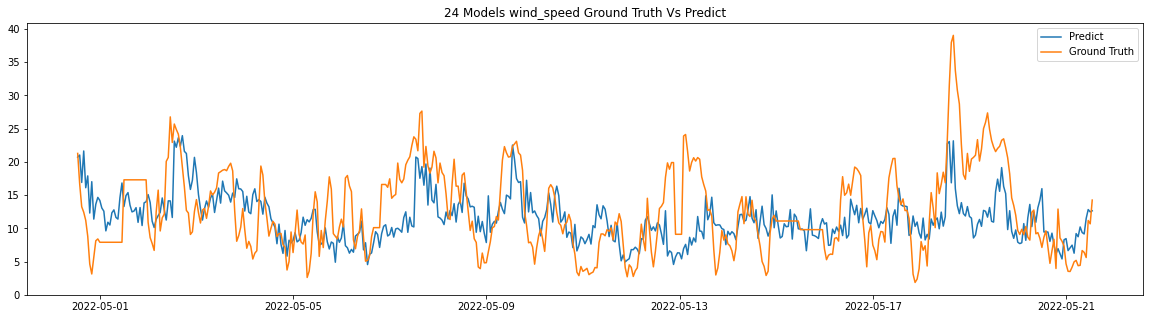

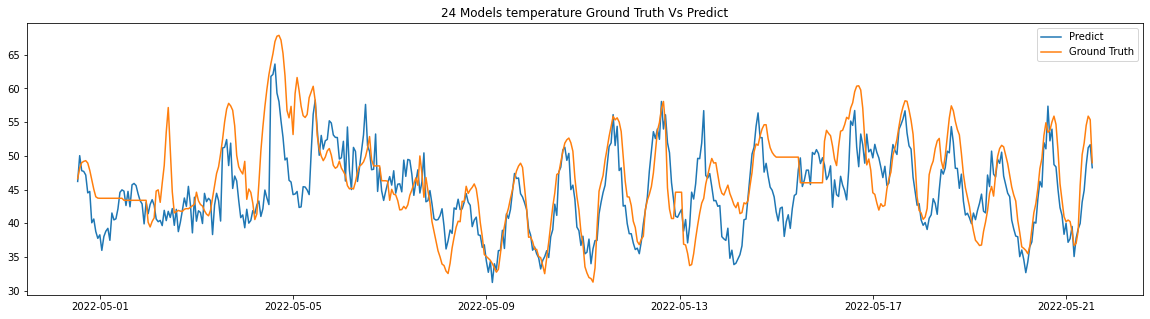

In [13]:
base_data_df = base_data_df[(base_data_df.index >= predict_start_datetime) & (base_data_df.index <= predict_end_datetime)]
for predict in MODEL_OUT_FEATURES:
    plt.figure(figsize=(20, 5))
    plt.plot(df_out["date"].values, df_out[predict].values)
    plt.plot(base_data_df.index.values, base_data_df[predict].values)
    plt.title(f"24 Models {predict} Ground Truth Vs Predict")
    plt.legend(["Predict", "Ground Truth"])